<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Time Series Properties, Autoregressive, and Moving Average Models

_Authors: Kiefer Katovich (SF)_

---
<a id="learning-objectives"></a>
<a id="learning-objectives"></a>

### Learning Objectives

- "Rolling" statistics through time, such as the rolling mean.
- Exponentially weighted statistics.
- Autocorrelation and partial autocorrelation.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

sns.set_style('whitegrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<a id="load-the-unemployment-data"></a>
<a id="load-the-unemployment-data"></a>
## Load the Unemployment Data
---

This is historical quarterly data regarding unemployment rates in the United States. First, perform any necessary cleaning.

In [2]:
data = pd.read_csv('../datasets/seasonally-adjusted-quarterly-us.csv')

In [3]:
data.head()

,Quarter,Seasonally adjusted quarterly U.S. unemployment rates from 1948 to 1993
0,1948Q1,3.733%
1,1948Q2,3.667%
2,1948Q3,3.767%
3,1948Q4,3.833%
4,1949Q1,4.667%


In [4]:
data.columns = ['year_quarter', 'unemployment_rate']
data['unemployment_rate'] = data['unemployment_rate'].map(lambda x: float(str(x).replace('%','')))
data.dropna(inplace=True)

In [5]:
data.head()

,year_quarter,unemployment_rate
0,1948Q1,3.733
1,1948Q2,3.667
2,1948Q3,3.767
3,1948Q4,3.833
4,1949Q1,4.667


In [6]:
data.dtypes

year_quarter          object
unemployment_rate    float64
dtype: object

<a id="create-a-datetime-index"></a>
<a id="create-a-datetime-index"></a>
## Create a Datetime Index
---

This is quarterly data, so converting to datetime is a bit complicated. `.dt.to_period('Q')` will help us represent the string as a datetime object.

In [7]:
data['date'] = pd.to_datetime(data.year_quarter).dt.to_period('Q')
data.set_index('date', inplace=True, drop=True)
data.head()

,year_quarter,unemployment_rate
date,,
1948Q1,1948Q1,3.733
1948Q2,1948Q2,3.667
1948Q3,1948Q3,3.767
1948Q4,1948Q4,3.833
1949Q1,1949Q1,4.667


<a id="visually-examine-the-unemployment-rate"></a>
<a id="visually-examine-the-unemployment-rate"></a>
## Visually Examine the Unemployment Rate
---

Plot the unemployment rate.

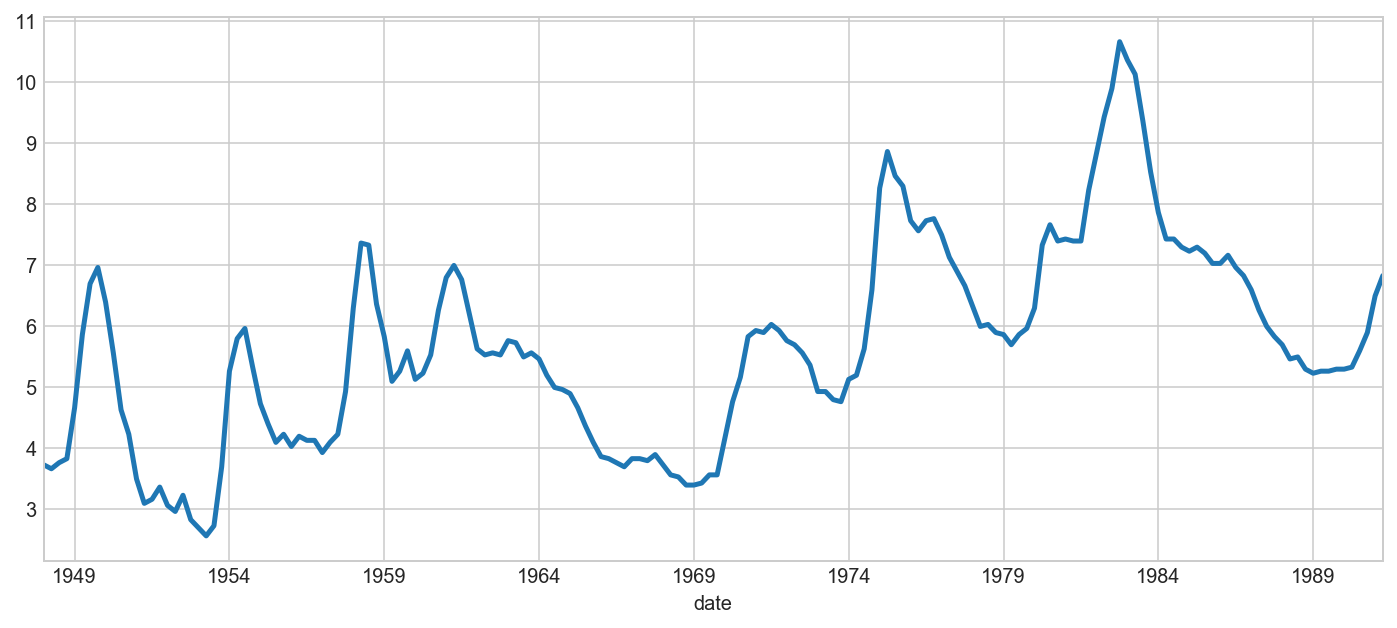

In [8]:
data['unemployment_rate'].plot(lw=2.5, figsize=(12,5))

<a id="rolling-functions"></a>
<a id="rolling-functions"></a>
## "Rolling" Functions
---

With time series, we can "roll" statistics across time. For example, the rolling mean is the mean of a moving window across time periods. Pandas offers a variety of functionalities for creating rolling statistics, which we'll only scratch the surface of here. 

The syntax for these can be a little tricky at first. We'll be using a `rolling()` function with a statistical function chained to it. Let's dive into more detail.

<a id="parameters-for-rolling-functions"></a>
<a id="parameters-for-rolling-functions"></a>
### Parameters for `rolling()` Functions

**`rolling().mean()`** (as well as **`rolling().median()`**) can take the following parameters:

- The first indicates the time series to aggregate.
- **`window`** indicates the number of days to include in the average.
- **`center`** indicates whether the window should be centered on the date or use data prior to that date.
- **`freq`** indicates which level to roll the averages up to (as used in **`resample`**): **`D`** for day, **`M`** for month, **`A`** for year, etc.

> **Note:** For more information, see Pandas' [resample documentation](http://stackoverflow.com/questions/17001389/pandas-resample-documentation).

**Calculate the rolling mean of years with `window=3` and without centering.**

In [9]:
yearly = data['unemployment_rate'].resample('A').mean().rolling(window=3, center=False).mean()
yearly.head()

date
1948         NaN
1949         NaN
1950    5.002833
1951    4.847333
1952    3.838917
Freq: A-DEC, Name: unemployment_rate, dtype: float64

**Extract the dates from the index as timestamps.**

> *Hint: The `.to_timestamp()` function allows you to extract the timestamps.*

In [10]:
date_ticks_orig = data.index.to_timestamp()
date_ticks_roll = yearly.index.to_timestamp()

**Use the timestamps you extracted to label your plot's index.**

Plot both the original unemployment rate values as well as the rolling mean.

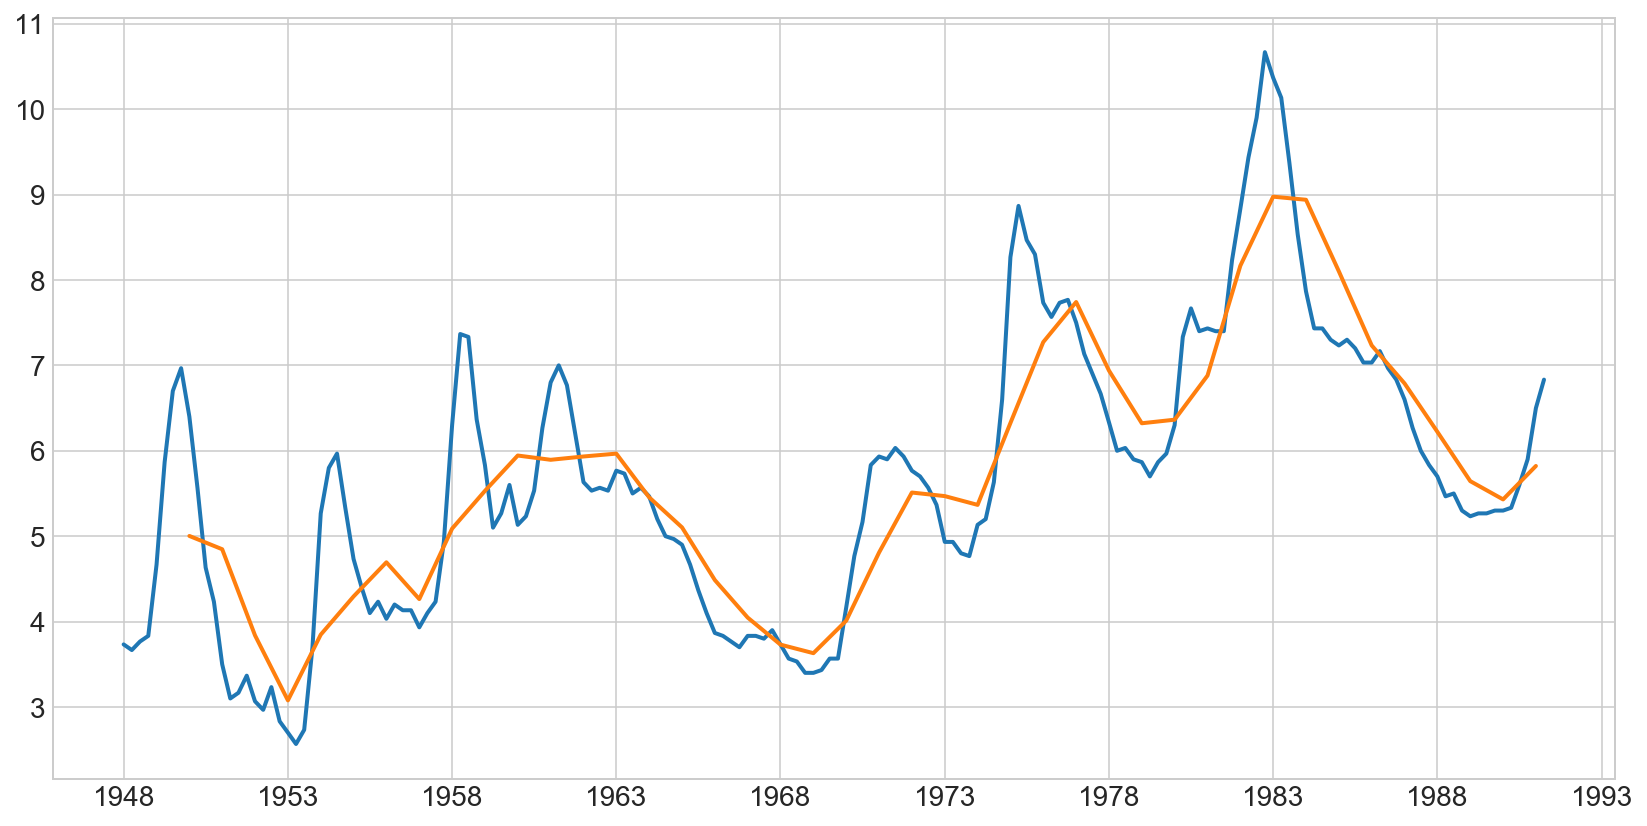

In [11]:
plt.figure(figsize=(14,7))

plt.plot(date_ticks_orig, data.unemployment_rate.values,lw=2)
plt.plot(date_ticks_roll, yearly.values, lw=2)

plt.tick_params(labelsize=14)

**Calculate the rolling median with `window=5` and `window=15`. Plot both together.**

In [12]:
uroll_w5 = data.unemployment_rate.rolling(window=5).median()
uroll_w15 = data.unemployment_rate.rolling(window=15).median()

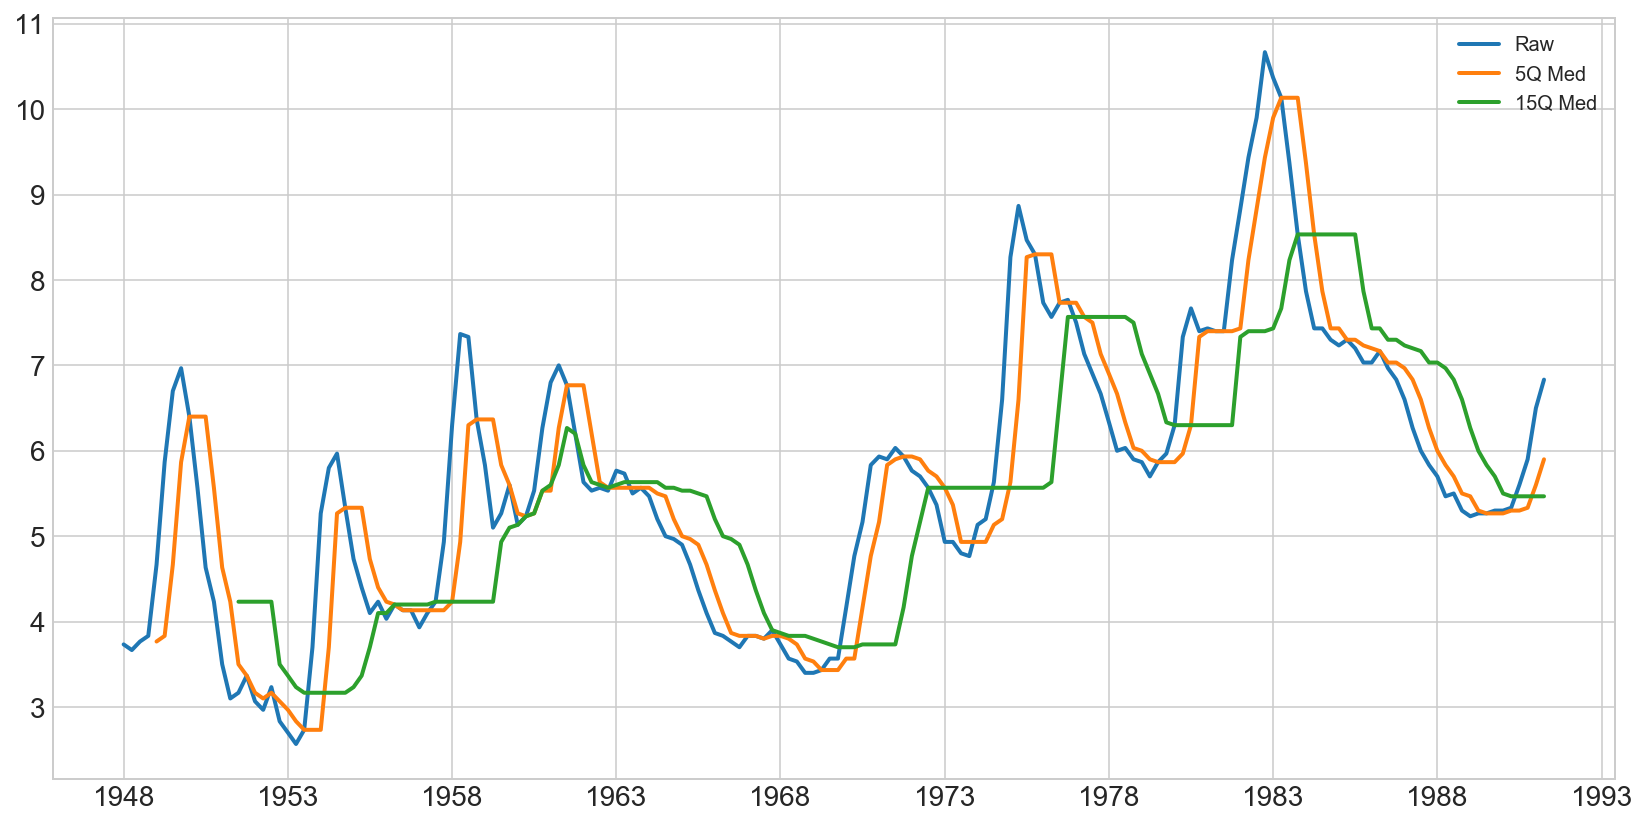

In [13]:
plt.figure(figsize=(14,7))

plt.plot(date_ticks_orig, data.unemployment_rate.values,lw=2,label='Raw')
plt.plot(date_ticks_orig, uroll_w5, lw=2,label='5Q Med')
plt.plot(date_ticks_orig, uroll_w15, lw=2,label='15Q Med')

plt.tick_params(labelsize=14)
plt.legend()

<a id="the-expanding-mean"></a>
<a id="the-expanding-mean"></a>
## The Expanding Mean
---

The "expanding mean" simply uses all data points up to the current time to calculate the mean, as opposed to a moving window.

**Calculate and plot the expanding mean below. Resample by quarter.**

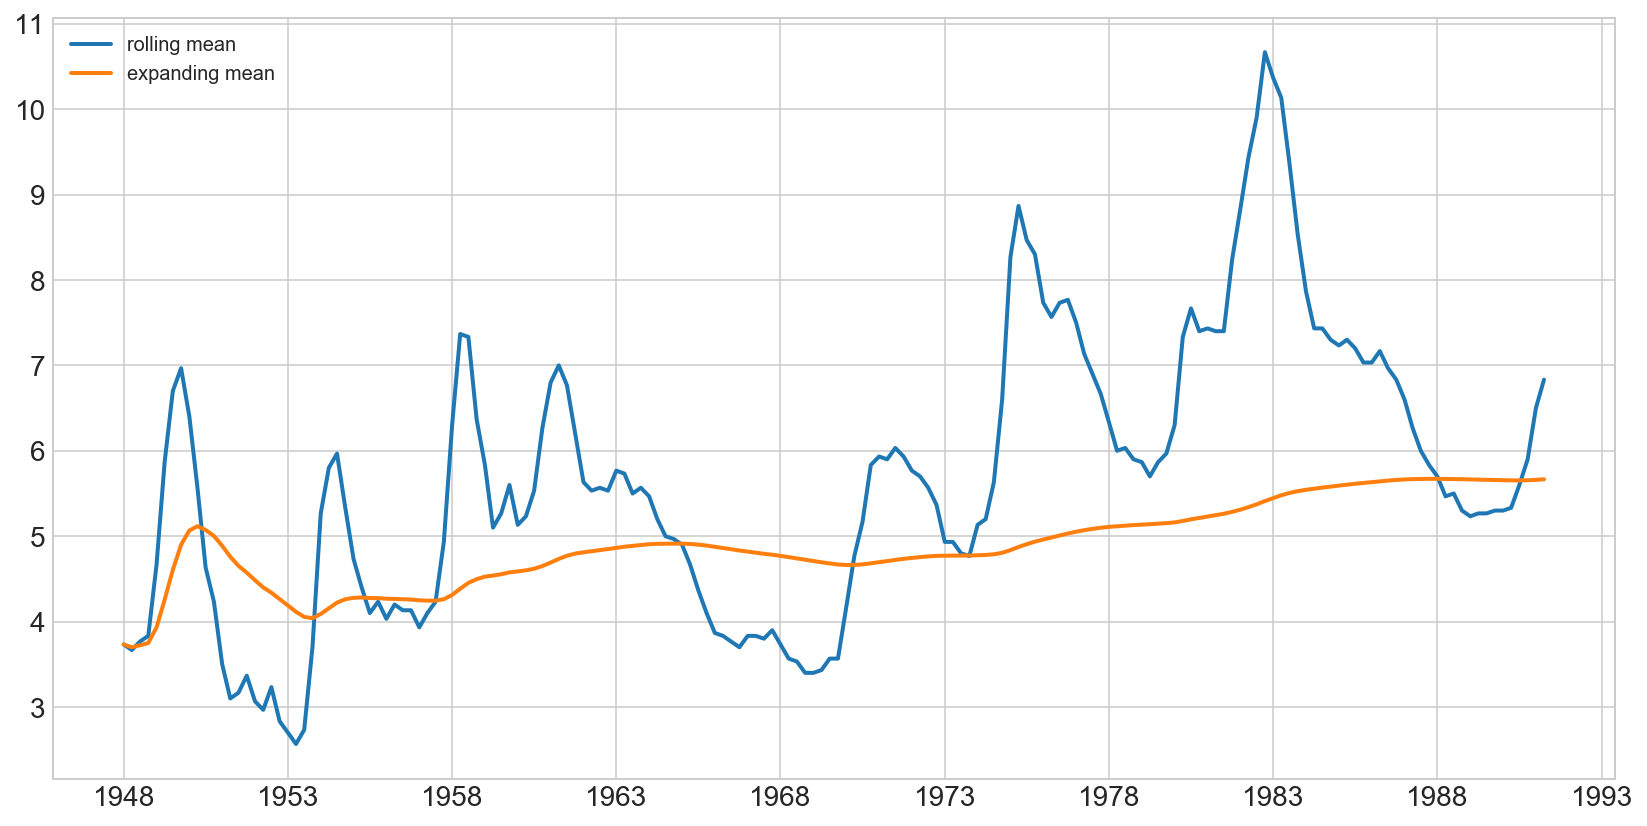

In [14]:
date_ticks = data.index.to_timestamp()

rolling_mean = data.unemployment_rate.resample('Q').sum().rolling(window=1, center=False).mean()
expanding_mean = data.unemployment_rate.resample('Q').sum().expanding().mean()

plt.figure(figsize=(14,7))

plt.plot(date_ticks, rolling_mean, alpha=1, lw=2, label='rolling mean')
plt.plot(date_ticks, expanding_mean, alpha=1, lw=2, label='expanding mean')

plt.legend(loc='upper left')

plt.tick_params(labelsize=14)

<a id="exponentially-weighted-windows"></a>
<a id="exponentially-weighted-windows"></a>
## Exponentially Weighted Windows
---

Exponentially weighted windows are one of the most common and effective ways of averaging out noise in time series data. The averaging is done with an "exponential decay" on the contribution of prior means, decreasing the contribution of time points that are further in the past.

The (adjusted) exponentially weighted mean for time, $t$, is defined as:

<a id="-xt--fracxt-----alphaxt------alphaxt--------alphatx------alpha-----alpha-------alphat-"></a>
### $$ x_t = \frac{x_t + (1 - \alpha)x_{t-1} + (1 - \alpha)^2x_{t-1} + ... + (1 - \alpha)^{t}x_0} {1 + (1 - \alpha) + (1 - \alpha)^2 + ... + (1 - \alpha)^{t}} $$

> **Note:** Review Pandas' [documentation](http://pandas.pydata.org/pandas-docs/stable/computation.html#exponentially-weighted-windows) for more information.

**Calculate and plot the exponentially weighted sum along with the rolling sum. What is the difference?**

For example: `.resample('Q').sum().ewm(span=10).mean()`.

In [15]:
rolling_mean = data.unemployment_rate.resample('Q').sum().rolling(window=2, center=True).mean()
exp_weighted_mean = data.unemployment_rate.resample('Q').sum().ewm(span=10).mean()

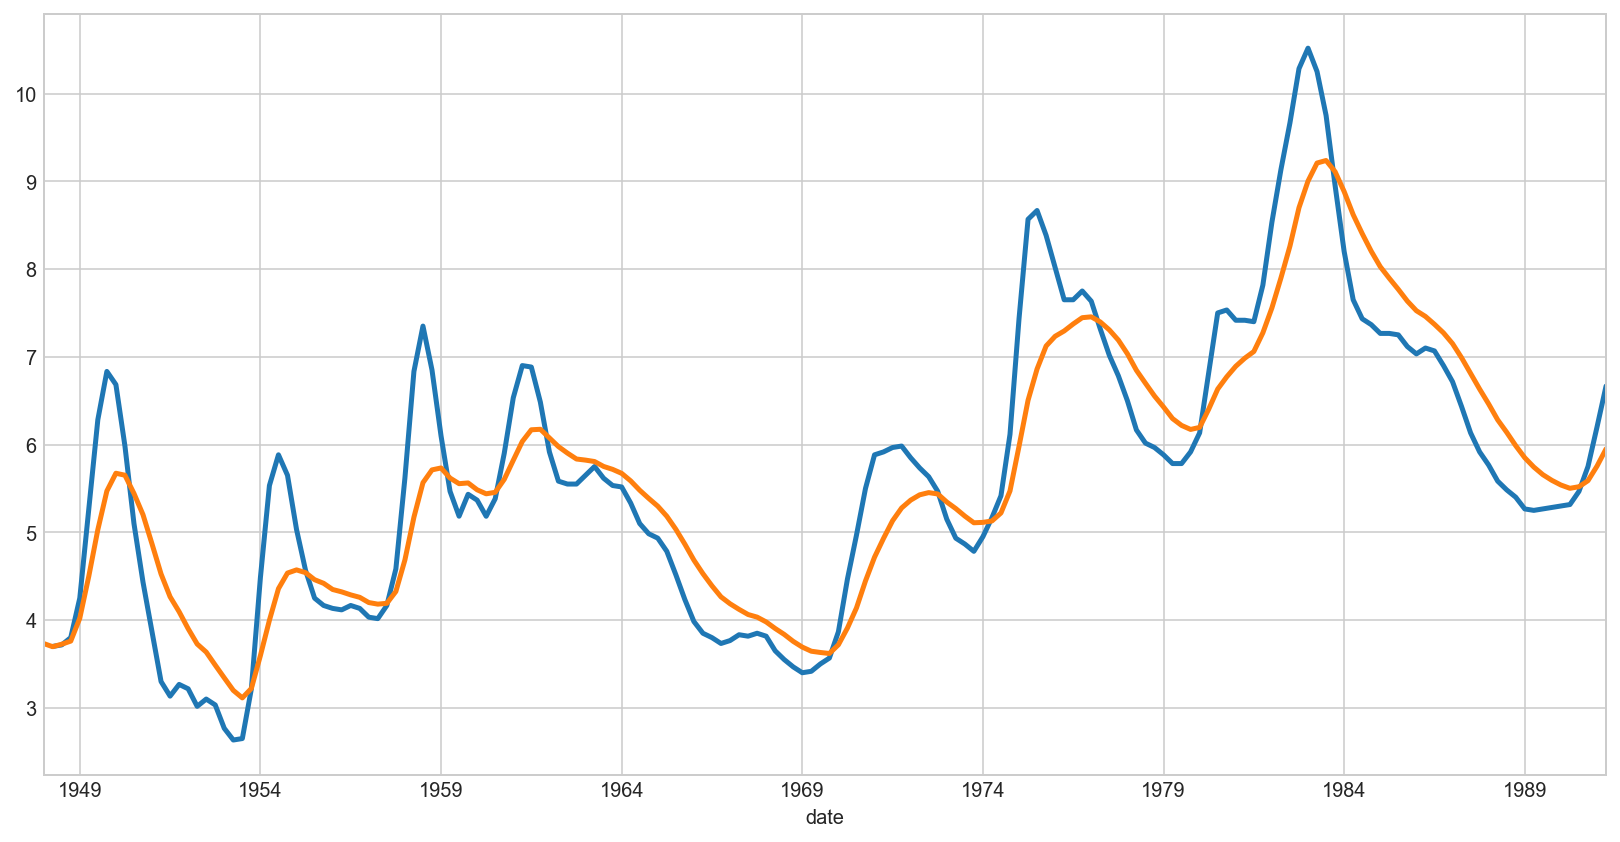

In [16]:
ax = rolling_mean.plot(lw=2.5, figsize=(14,7))
exp_weighted_mean.plot(ax=ax, lw=2.5)

<a id="autocorrelation-and-the-autocorrelation-function-acf"></a>
<a id="autocorrelation-and-the-autocorrelation-function-acf"></a>
##  Autocorrelation and the Autocorrelation Function (ACF)
---

In previous weeks, our analyses have been concerned with the correlation between two or more variables (height and weight, education and salary, etc.). In time series data, autocorrelation is a measure of _how correlated a variable is with itself_.

Specifically, autocorrelation measures how closely earlier values relate to values that occur later in time.

Examples of autocorrelation are:

    In stock market data, the stock price at one point is correlated with the stock 
    price of the point that's directly prior in time. 
    
    In sales data, sales on a Saturday are likely correlated with 
    sales on the next Saturday and the previous Saturday, as well as other days to more
    or less of an extent.

Below is the formula for the autocorrelation function (ACF):

$\text{Given measurements } x_1, x_2, x_3 ... x_n \text{ at time points } t_1, t_2, t_3 ... t_n:$

### $$lag_k\;acf() = \frac{\sum_{t=k+1}^{n}\left(\;x_t - \bar{x}\;\right)\left(\;x_{t-k} - \bar{x}\;\right)}{\sum_{t=1}^n\left(\;x_t - \bar{x}\;\right)^2}$$

Compare this to the formula for correlation:

$\text{Given measurements } x_1, x_2, x_3 ... x_n \text{ and measurements } y_1, y_2, y_3 ... y_n:$

### $$r_{xy} = \frac{\sum_{i=1}^{n}\left(\;x_i - \bar{x}\;\right)\left(\;y_{i} - \bar{y}\;\right)}{\sqrt{\left(\sum_{i=1}^{n}\left(\;x_i - \bar{x}\;\right)^2\sum_{i=1}^n\left(\;y_i - \bar{y}\;\right)^2\right)}}$$


<a id="computing-autocorrelation"></a>
<a id="computing-autocorrelation"></a>
### Computing Autocorrelation

To compute autocorrelation, we fix a lag, _k_, which is the delta between the given point and the prior point used to compute the correlation.

With a _k_ value of 1, we'd compute how correlated a value is with the value that's immediately prior. With a _k_ value of 10, we'd compute how correlated a variable is with the value that's 10 time points prior.

In [32]:
autocorr_quarter_lag1 = data.unemployment_rate.resample('Q').mean().autocorr(lag=1)
autocorr_year_lag1 = data.unemployment_rate.resample('A').mean().autocorr(lag=1)

print(autocorr_quarter_lag1)
print(autocorr_year_lag1)

0.964806918709
0.734442071554


<a id="autocorrelation-using-statsmodels"></a>
<a id="autocorrelation-using-statsmodels"></a>
### Autocorrelation Using Statsmodels

Statsmodels comes with some convenient packages for calculating and plotting autocorrelation. Load up these two functions and try them out:

```python
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
```

In [20]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

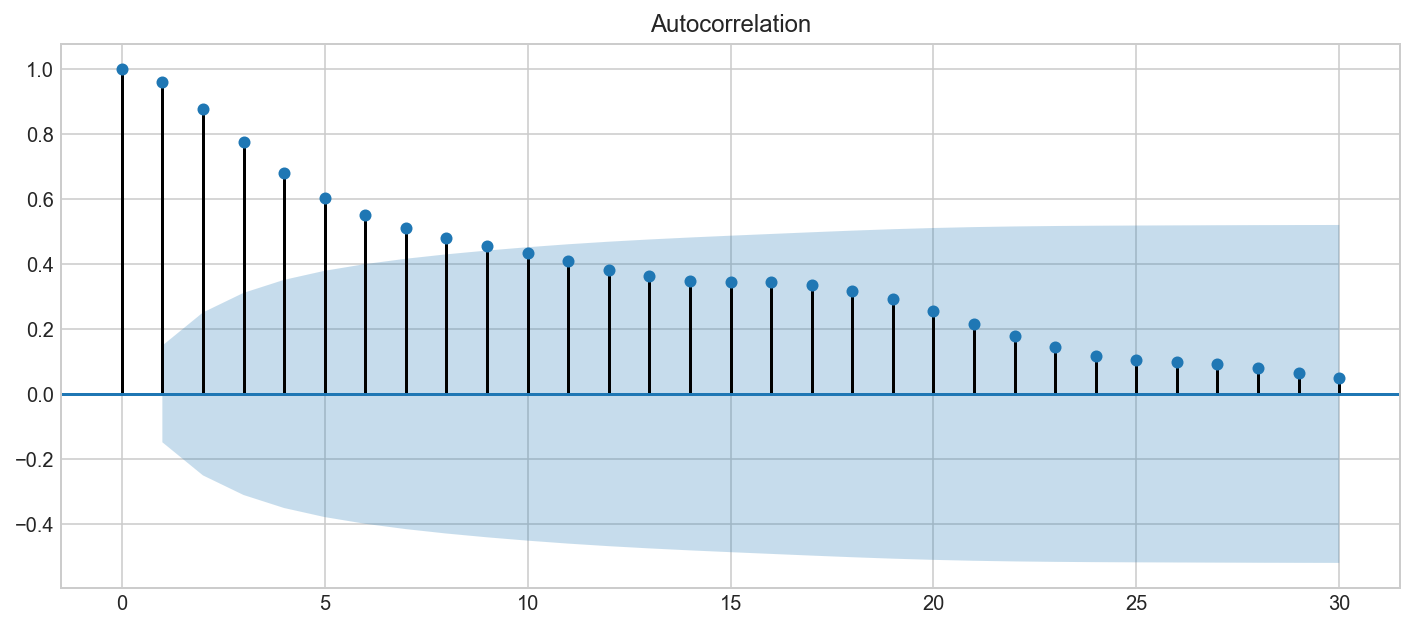

In [22]:
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(data.unemployment_rate, lags=30, ax=ax)
plt.show()

In [24]:
acf(data.unemployment_rate.values)

array([ 1.        ,  0.95950578,  0.87513008,  0.77480906,  0.67860558,
        0.60302767,  0.54946953,  0.50980855,  0.47862666,  0.45530485,
        0.43290704,  0.40733564,  0.38242446,  0.36262662,  0.34831031,
        0.34311303,  0.34269765,  0.33602242,  0.31802897,  0.29043284,
        0.25556895,  0.2160284 ,  0.17728841,  0.14298489,  0.1174645 ,
        0.10443249,  0.0983227 ,  0.09189054,  0.07989638,  0.06491514,
        0.0504506 ,  0.03938976,  0.03186116,  0.02577897,  0.01922499,
        0.00854907, -0.00629097, -0.0236317 , -0.03795652, -0.04774544,
       -0.04766326])

<a id="partial-autocorrelation-and-the-partial-autocorrelation-function-pacf"></a>
<a id="partial-autocorrelation-and-the-partial-autocorrelation-function-pacf"></a>
## Partial Autocorrelation and the Partial Autocorrelation Function (PACF)
---

Another important chart for diagnosing your time series is the partial autocorrelation chart (PACF). This is similar to autocorrelation, but, instead of being just the correlation at increasing lags, it is the correlation at a given lag, _controlling for the effect of previous lags._

Load up the sister functions for partial autocorrelation from Statsmodels and test them out on the differenced time series.

```python
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
```

In [25]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

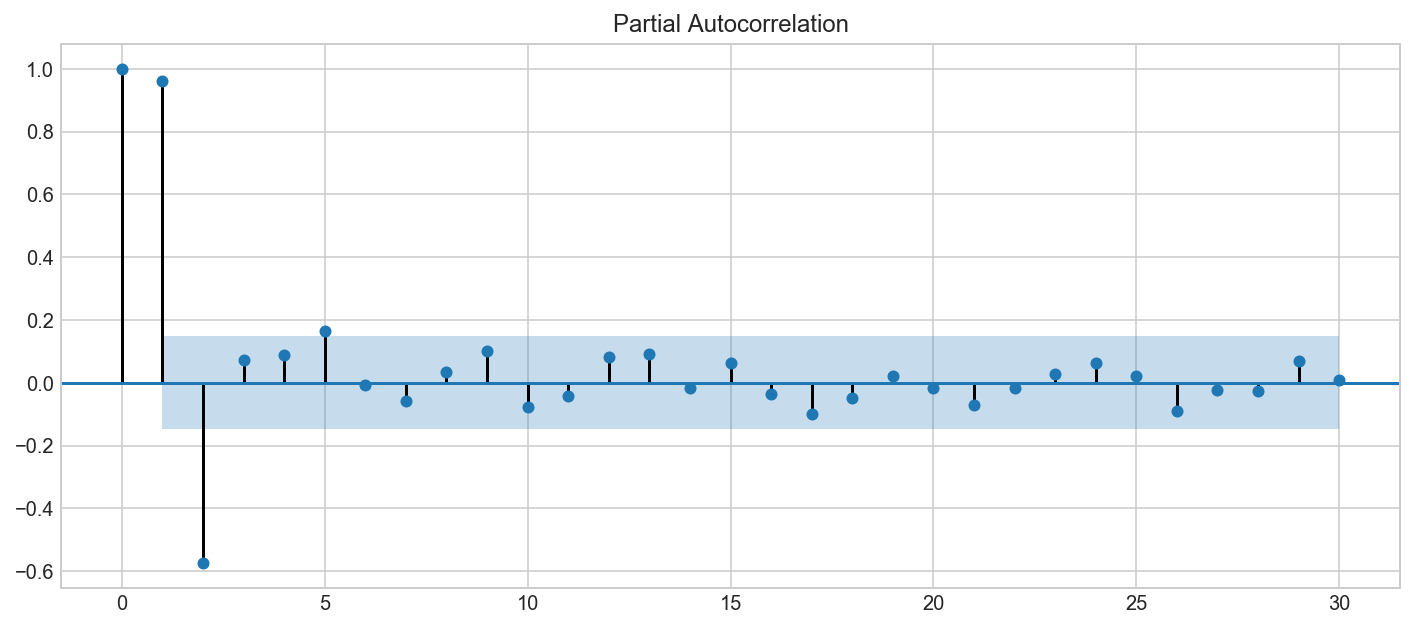

In [26]:
fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(data.unemployment_rate, lags=30, ax=ax)
plt.show()

In [28]:
pacf(data.unemployment_rate)

array([ 1.        ,  0.96505205, -0.67010933,  0.21691526,  0.07494577,
        0.21322536, -0.09593115, -0.05491075,  0.07521878,  0.14700603,
       -0.18064033, -0.01381037,  0.1414165 ,  0.13517355, -0.10704305,
        0.10418921, -0.0958789 , -0.08324834, -0.07692577,  0.08321147,
       -0.05132902, -0.10983221, -0.02697883,  0.11522708,  0.08706447,
       -0.04999405, -0.211133  ,  0.10306874, -0.03625734,  0.15691032,
       -0.13314136,  0.02109581, -0.11693186,  0.14926814, -0.08634752,
       -0.11964679, -0.04801546,  0.18371963,  0.17030783, -0.15981006,
        0.10459434])